In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = np.repeat(np.expand_dims(x_train / 255.0 , -1), 3, axis = -1).astype(np.float32)
x_test = np.repeat(np.expand_dims(x_test / 255.0, -1), 3, axis = -1).astype(np.float32)
y_train = np.eye(10)[np.reshape(y_train, -1)].astype(np.float32)
y_test = np.eye(10)[np.reshape(y_test, - 1)].astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

def xy_visualization(x, y):  
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    print(y)
    

In [ ]:
Grid Mask

In [ ]:
import os
import numpy as np
import tensorflow as tf
import math

def transform(image, inv_mat, image_shape):
    h, w, c = image_shape
    cx, cy = w//2, h//2
    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)
    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)
    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)
    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))
    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))
    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):
    def get_rotation_mat_inv(angle):
        # transform to radian
        angle = math.pi * angle / 180
        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)
        rot_mat_inv = tf.concat([cos_val, sin_val, zero, -sin_val, cos_val, zero, zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])
        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):
    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges < 0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges < 0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape):
    AugParams = {
        'd1' : 100,
        'd2': 160,
        'rotate' : 45,
        'ratio' : 0.3
    }
    mask = GridMask(image_shape[0], image_shape[1], AugParams['d1'], AugParams['d2'], AugParams['rotate'], AugParams['ratio'])
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)
    return image * tf.cast(mask, tf.float32)


def gridmask(img_batch, label_batch, batch_size):
    return apply_grid_mask(img_batch, (160, 256, 3)), label_batch

In [ ]:
Augmix

# Cutmix
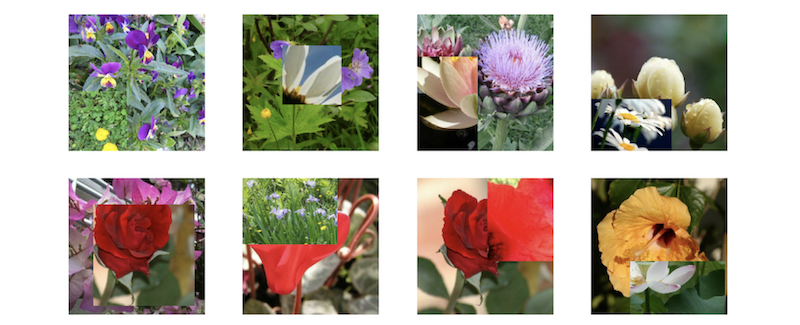

In [ ]:
@tf.function
def cutmix(img_batch, label_batch):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    img_h, img_w, img_channels = tf.shape(img_batch)[1], tf.shape(img_batch)[2], tf.shape(img_batch)[3]
    batch_size, num_classes = tf.shape(label_batch)[0], tf.shape(label_batch)[1]
    
    img_batch_new = tf.zeros((batch_size, img_h, img_w, img_channels), tf.float32)
    label_batch_new = tf.zeros((batch_size, num_classes), tf.float32)
    
    # CHOOSE RANDOM LOCATION
    cut_xs = tf.cast(tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32)), tf.int32)
    cut_ys = tf.cast(tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32)), tf.int32)
    cut_ratios = tf.math.sqrt(1 - tf.random.uniform([batch_size], 0, 1)) # cut ratio
    cut_ws = tf.cast(tf.cast(img_w, tf.float32) * cut_ratios, tf.int32)
    cut_hs = tf.cast(tf.cast(img_h, tf.float32) * cut_ratios, tf.int32)
    yas = tf.math.maximum(0, cut_ys - cut_hs // 2)
    ybs = tf.math.minimum(img_h, cut_ys + cut_hs // 2)
    xas = tf.math.maximum(0, cut_xs - cut_ws // 2)
    xbs = tf.math.minimum(img_w, cut_xs + cut_ws // 2)
    # CHOOSE RANDOM IMAGE TO CUTMIX WITH
    js = tf.cast(tf.random.uniform([batch_size], 0, tf.cast(batch_size, tf.float32)), tf.int32)
        
    for i in tf.range(batch_size):
        ya, yb, xa, xb, j = yas[i], ybs[i], xas[i], xbs[i], js[i]
        img_org, img_cut, label_org, label_cut = img_batch[i], img_batch[j], label_batch[i], label_batch[j]
        # MAKE CUTMIX IMAGE
        img_org_left_middle = img_org[ya:yb,0:xa,:]
        img_cut = img_cut[ya:yb,xa:xb,:]
        img_org_right_middle = img_org[ya:yb,xb:img_w,:]
        img_middle = tf.concat([img_org_left_middle, img_cut, img_org_right_middle], axis=1)
        img_cutmix = tf.concat([img_org[0:ya,:,:], img_middle, img_org[yb:img_h,:,:]], axis=0)
        img_batch_new[i].assign(img_cutmix)
        # MAKE CUTMIX LABEL
        label_weight = tf.cast((yb - ya) * (xb - xa) / (img_h * img_w), tf.float32)
        label_cutmix = (1 - label_weight) * label_org + label_weight * label_cut
        label_batch_new[i].assign(ilabel_cutmix)
            
    return img_batch_new, label_batch_new

batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(20).repeat(1).batch(512)
batch = batch.map(lambda a, b : cutmix(a, b))
    
x, y = batch.__iter__().__next__()
xy_visualization(x[0], y[0])

# Mixup
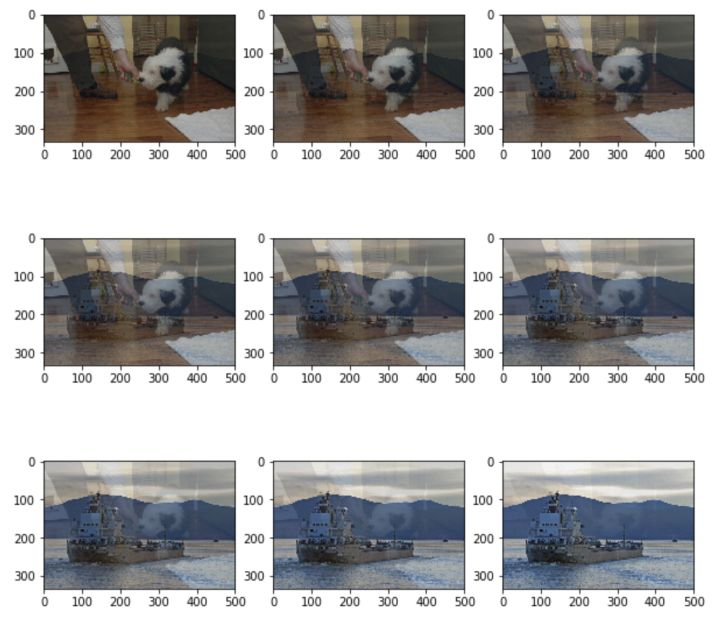

In [ ]:
def mixup(img_batch, label_batch):
    # img_batch [N, image_h, img_w, img_channels]
    # label_batch [N, num_classes]
    batch_size = tf.shape(img_batch)[0]
    weight = tf.math.sqrt(1 - tf.random.uniform([batch_size])) #beta distribution
    x_weight = tf.reshape(weight, [batch_size, 1, 1, 1])
    y_weight = tf.reshape(weight, [batch_size, 1])
    index = tf.random.shuffle(tf.range(batch_size, dtype=tf.int32))
    x1, x2 = img_batch, tf.gather(img_batch, index)
    img_batch = x1 * x_weight + x2 * (1. - x_weight)
    y1, y2 = label_batch, tf.gather(label_batch, index)
    label_batch = y1 * y_weight + y2 * (1. - y_weight)
    return img_batch, label_batch

batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(20).repeat(1).batch(512)
batch = batch.map(lambda a, b : mixup(a, b))
    
x, y = batch.__iter__().__next__()
xy_visualization(x[0], y[0])